### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 5th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

#### Part 1

In [186]:
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from scipy import stats
from scipy.stats import uniform, loguniform
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import acor
import corner
import dynesty
from dynesty import plotting as dyplot

In [3]:
#reading in data file
data = np.load('/Users/petrop3/Repos/astr_8070_s22/coursework/homeworks/hw_data/hw5_data_1.npy')
time = data[:,0]
flux = data[:,1]
flux_sig = data[:,2] #homoscedastic measurement uncertainties on flux

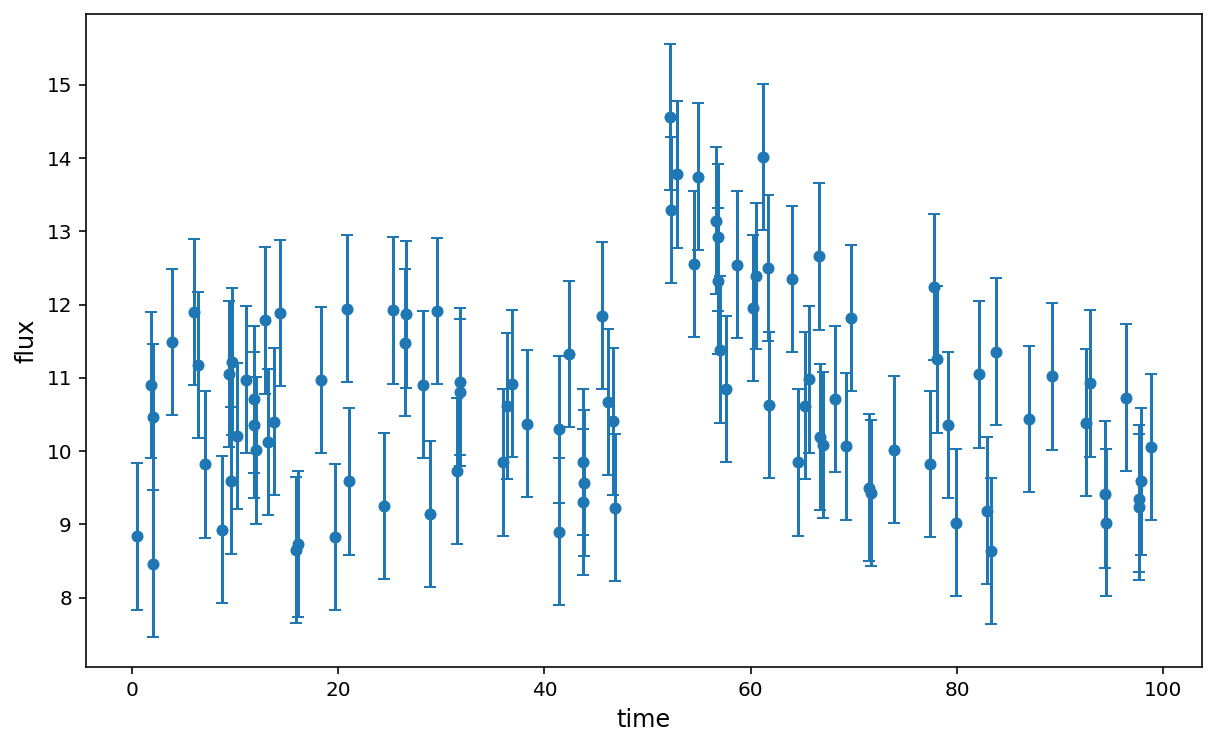

In [4]:
#plotting data with uncertainties
plt.figure(1, figsize=(10,6))
plt.errorbar(time, flux, yerr=flux_sig, marker='o', ms=5, ls='none', capsize=3)
plt.xlabel('time', fontsize=12)
plt.ylabel('flux', fontsize=12)
plt.show()

#### Part 2

In [176]:
#function for burst model
def burst_model(b, A, alpha, t0, t):
    y = np.ones_like(t)
    z_ind = np.where(t < t0)
    y[z_ind] *= b
    ind = np.where(t >= t0)
    y[ind] *= (b + A*np.exp(-alpha*(t[ind]-t0)))
    return y

In [178]:
#function for likelihood, with theta = [b, A, alpha, t0]
def logL(theta, model=burst_model):
    y_fit = model(b=theta[0], A=theta[1], alpha=theta[2], t0=theta[3], t=time)
    return sum(stats.norm.logpdf(*args) for args in zip(flux, y_fit, flux_sig))

#### Part 3

In [179]:
#4 uniform priors multiplied together: p(b)*p(A)*p(ln𝛼)*p(t0)
def prior(theta):
    p_b = uniform.pdf(theta[0], 0, 50)
    p_A = uniform.pdf(theta[1], 0, 50)
    p_lnalpha = uniform.pdf(theta[2], -5, 10)
    p_t0 = uniform.pdf(theta[3], 0, 100)
    return p_b * p_A * p_lnalpha * p_t0

def logPrior(x):
    return np.log(prior(x))

SRT: All correct, Polina, but the code could be more compact by combining things for a single log-prior function. scipy.stats allows you to call the lodpdf attribute, which is then just added together to get the log prior. -2

In [181]:
#dimension of parameter space
ndim = 4

#initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

#intialize sampler
sampler = ptmcmc(ndim, logL, logPrior, cov, 
                 outDir='./hw5_part3_trial2', resume=True)

In [182]:
#sampler for N steps
N = int(5e5)
x0 = np.array([25.0, 25.0, 1.0, 50.0])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.20 percent in 4.768203 s Acceptance rate = 0.71

/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_33518/3560356527.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(prior(x))


Finished 2.00 percent in 45.430666 s Acceptance rate = 0.184433Adding DE jump with weight 50
Finished 99.80 percent in 2274.247119 s Acceptance rate = 0.230066
Run Complete


#### Part 4

In [187]:
#loading in the chain and file with parameter names
chain = np.loadtxt('./hw5_part3_trial2/chain_1.txt')

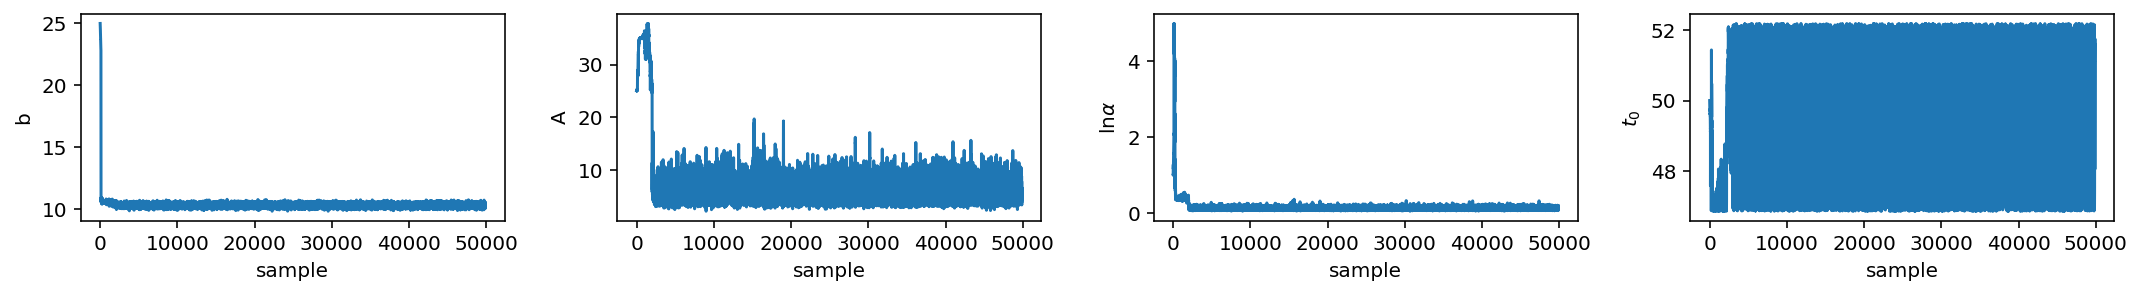

In [188]:
#plotting entire trace plots

params = ['b','A',r'ln$\alpha$',r'$t_0$']
burn = 0

plt.figure(1, figsize=(15, 2*19))
for i in range(4):
    plt.subplot(19, 4, i+1)
    plt.plot(chain[burn:,i],c='C0')
    plt.xlabel('sample')
    plt.ylabel(params[i])
plt.tight_layout()

Setting burn in to be the first quarter of the chain = the first 125000 samples. This is more than enough to exclude.

In [189]:
burn = int(len(chain)/4)

#getting autocorrelation length
acor_len = acor.acor(chain[burn:,0])[0]
print(acor_len)

3.588809036681531


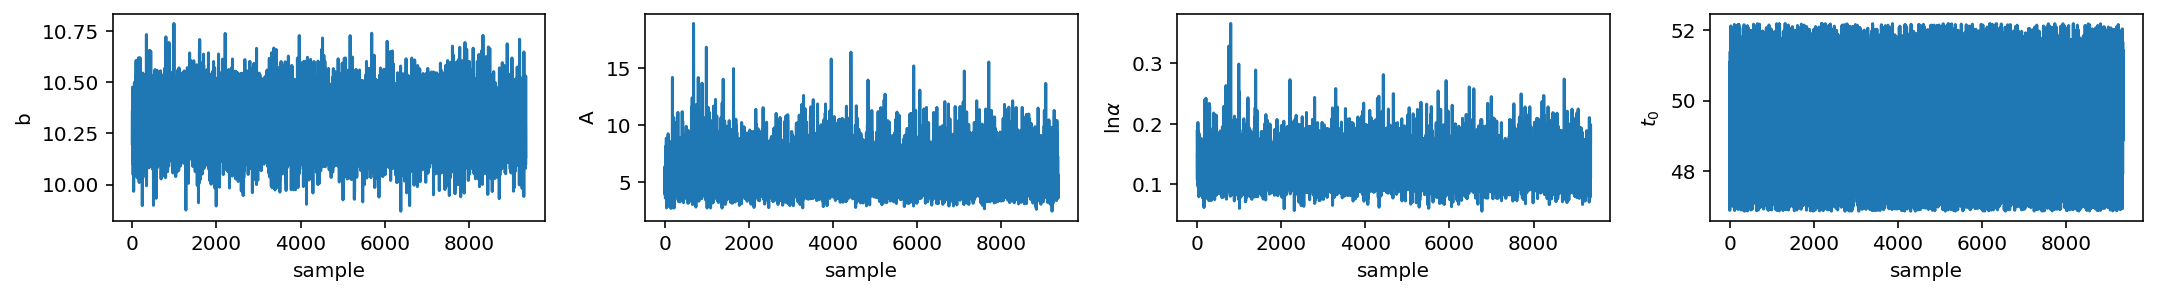

In [190]:
#plotting trace plots now implementing burn in (first 125000 samples) and autocorrelation length (6)
plt.figure(2, figsize=(15, 2*19))
for i in range(4):
    plt.subplot(19, 4, i+1)
    plt.plot(chain[burn::round(acor_len),i],c='C0')
    plt.xlabel('sample')
    plt.ylabel(params[i])
plt.tight_layout()

SRT: Very good.

#### Part 5

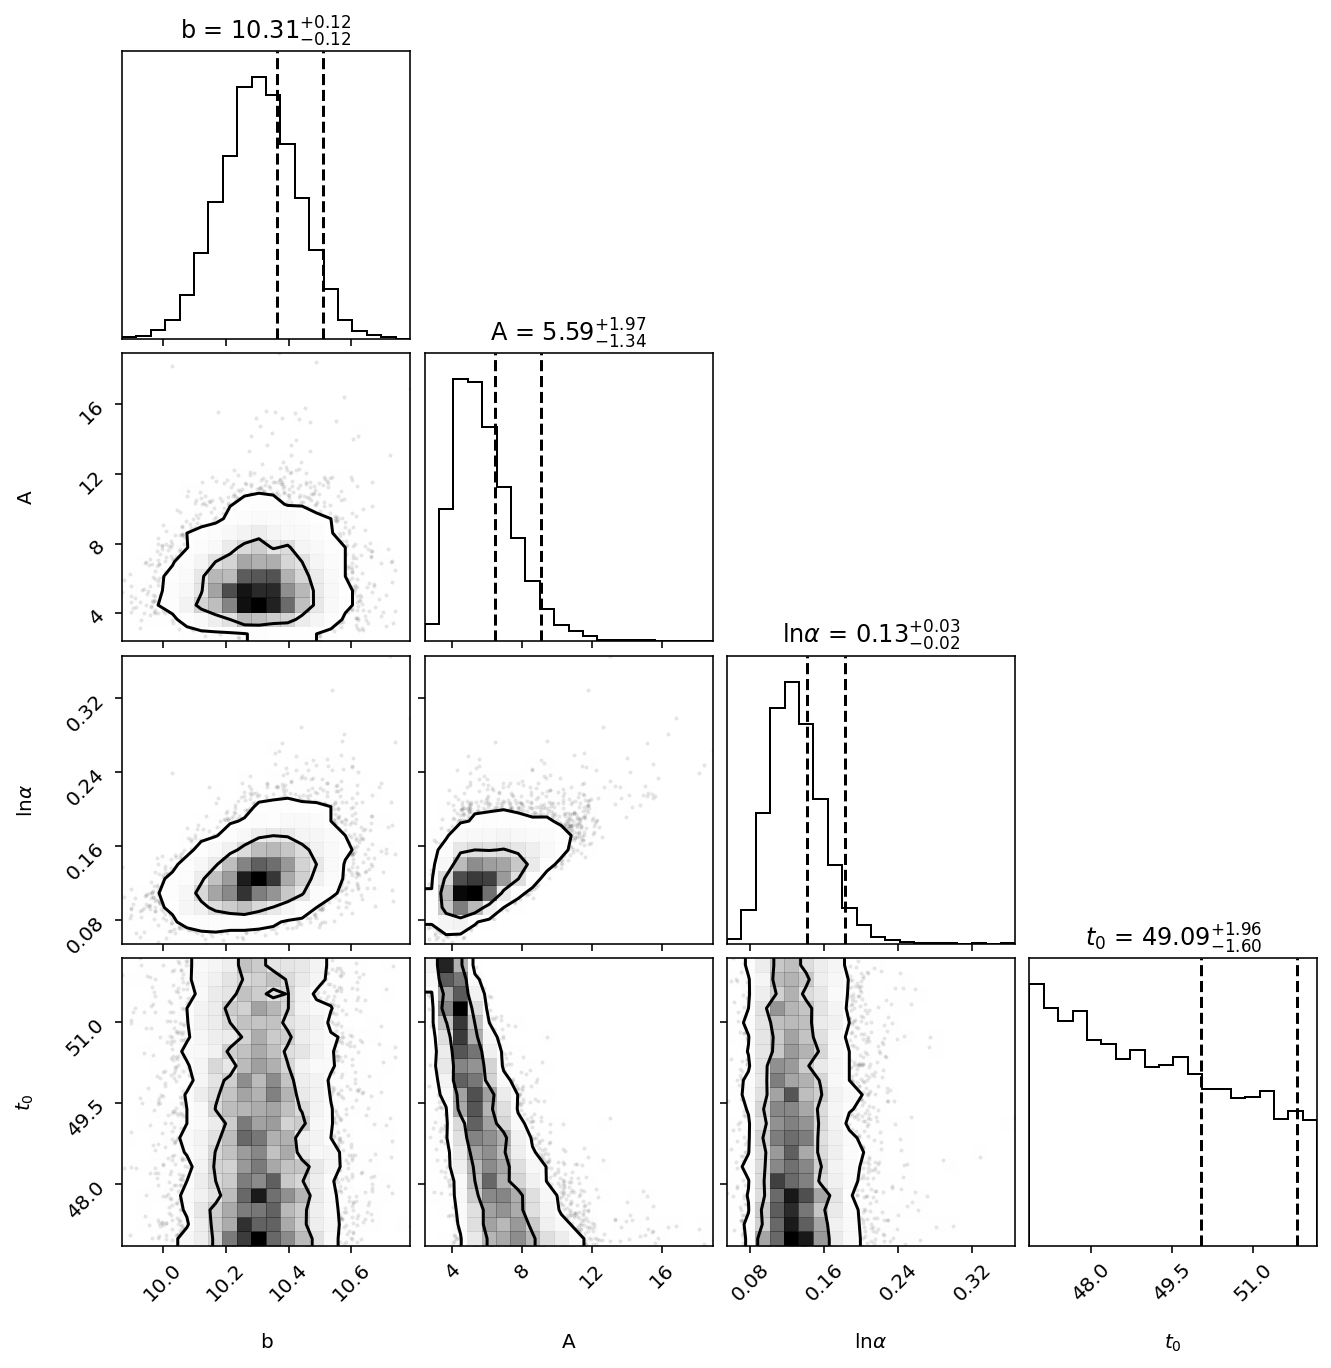

In [191]:
#corner plot of parameters
corner.corner(chain[burn::round(acor_len),0:4], labels=['b', 'A', r'ln$\alpha$', r'$t_0$'],
              levels=(0.68,0.95),
              quantiles=(0.68,0.95),
              titles=['b','A',r'ln$\alpha$',r'$t_0$'],
              title_kwargs={"fontsize": 12},
              show_titles=True)
plt.show()

#### Part 6

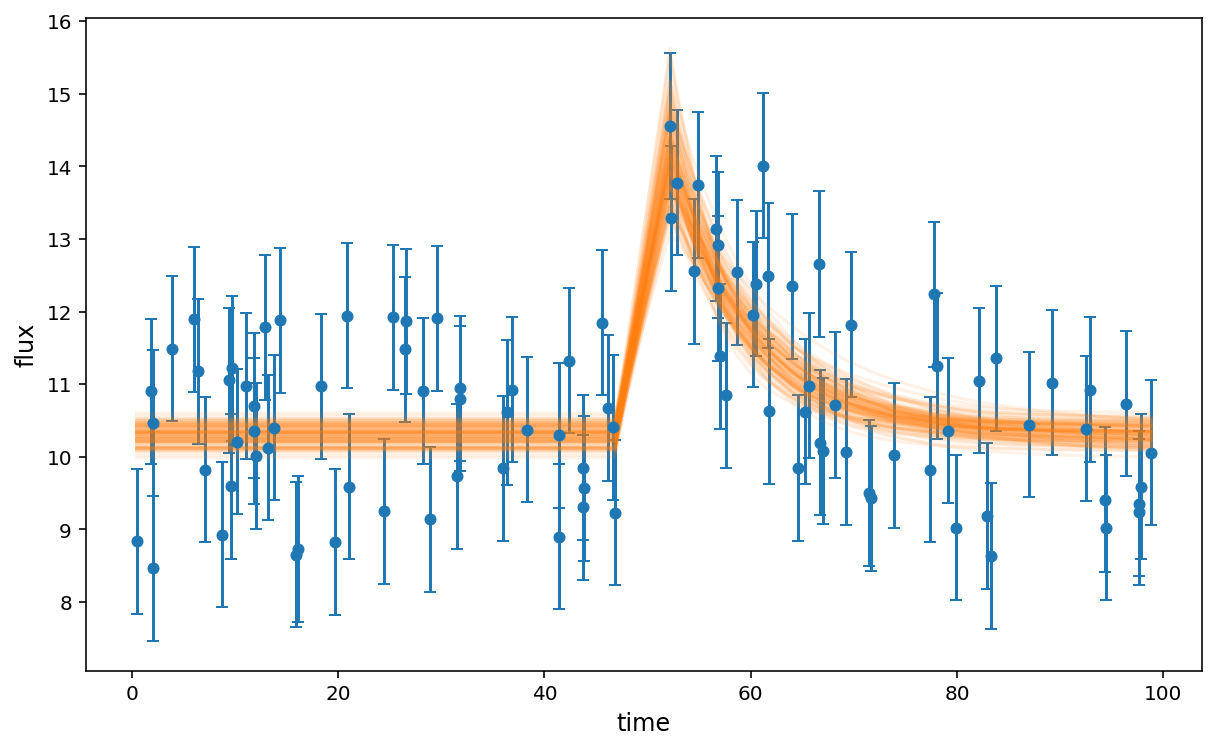

In [192]:
plt.figure(1, figsize=(10,6))
plt.errorbar(time, flux, yerr=flux_sig, marker='o', ms=5, ls='none', capsize=3, color='C0')
plt.xlabel('time', fontsize=12)
plt.ylabel('flux', fontsize=12)


Dchain = chain[burn::round(acor_len),0:4] #burned, thinned chain

indices = randint(0, len(Dchain), size=100, dtype=int)
for i in indices:
    b = Dchain[:,0][i]
    A = Dchain[:,1][i]
    alpha = Dchain[:,2][i]
    t0 = Dchain[:,3][i]
    plt.plot(time, burst_model(b, A, alpha, t0, time), alpha=0.1, color='C1')

plt.show()

SRT: Awesome work, Polina.

#### Part 7

In [204]:
#function for Gaussian profile
def gaussian_model(b, A, t0, sigW, t):
    y = b + A*np.exp(-(t-t0)**2/(2*sigW**2))
    return y

#function for likelihood, with theta = [b, A, t0, sigW]
def logL2(theta, model=gaussian_model):
    y_fit = model(b=theta[0], A=theta[1], t0=theta[2], sigW=theta[3], t=time)
    return sum(stats.norm.logpdf(*args) for args in zip(flux, y_fit, flux_sig))

#4 uniform priors multiplied together: p(b)*p(A)*p(t0)*p(sigW)
def prior(theta):
    p_b = uniform.pdf(theta[0], 0, 50)
    p_A = uniform.pdf(theta[1], 0, 50)
    p_t0 = uniform.pdf(theta[2], 0, 100)
    p_sigW = uniform.pdf(theta[3], -2, 10)
    return p_b * p_A * p_t0 * p_sigW

def logPrior(x):
    return np.log(prior(x))

In [205]:
#params in order b, A, lnalpha, t0
def ptform_burst(u):
    u_pt = np.zeros(4)
    u_pt[0] = u[0]*50
    u_pt[1] = u[1]*50
    u_pt[2] = 5*(2*u[2]-1)
    u_pt[3] = u[3]*100
    return(u_pt)

#params in order b, A, t0, sigW
def ptform_gaussian(u):
    u_pt = np.zeros(4)
    u_pt[0] = u[0]*50
    u_pt[1] = u[1]*50
    u_pt[2] = u[2]*100
    u_pt[3] = 2*(2*u[3]-1)
    return(u_pt)

SRT: It looks like you correctly put the prior on log-sigmaW, but then did not transform it to be sigW in the likelihood function or Gaussian burst functions. -3

In [195]:
#static nested sampling with burst model
sampler = dynesty.NestedSampler(logL, ptform_burst, 4) #ndim = 4
sampler.run_nested()
sresults_burst = sampler.results

/Users/petrop3/anaconda3/envs/astr8070/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:254: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
iter: 8681 | +500 | bound: 48 | nc: 1 | ncall: 55834 | eff(%): 16.443 | loglstar:   -inf < -140.655 <    inf | logz: -157.237 +/-    nan | dlogz:  0.001 >  0.509                                     

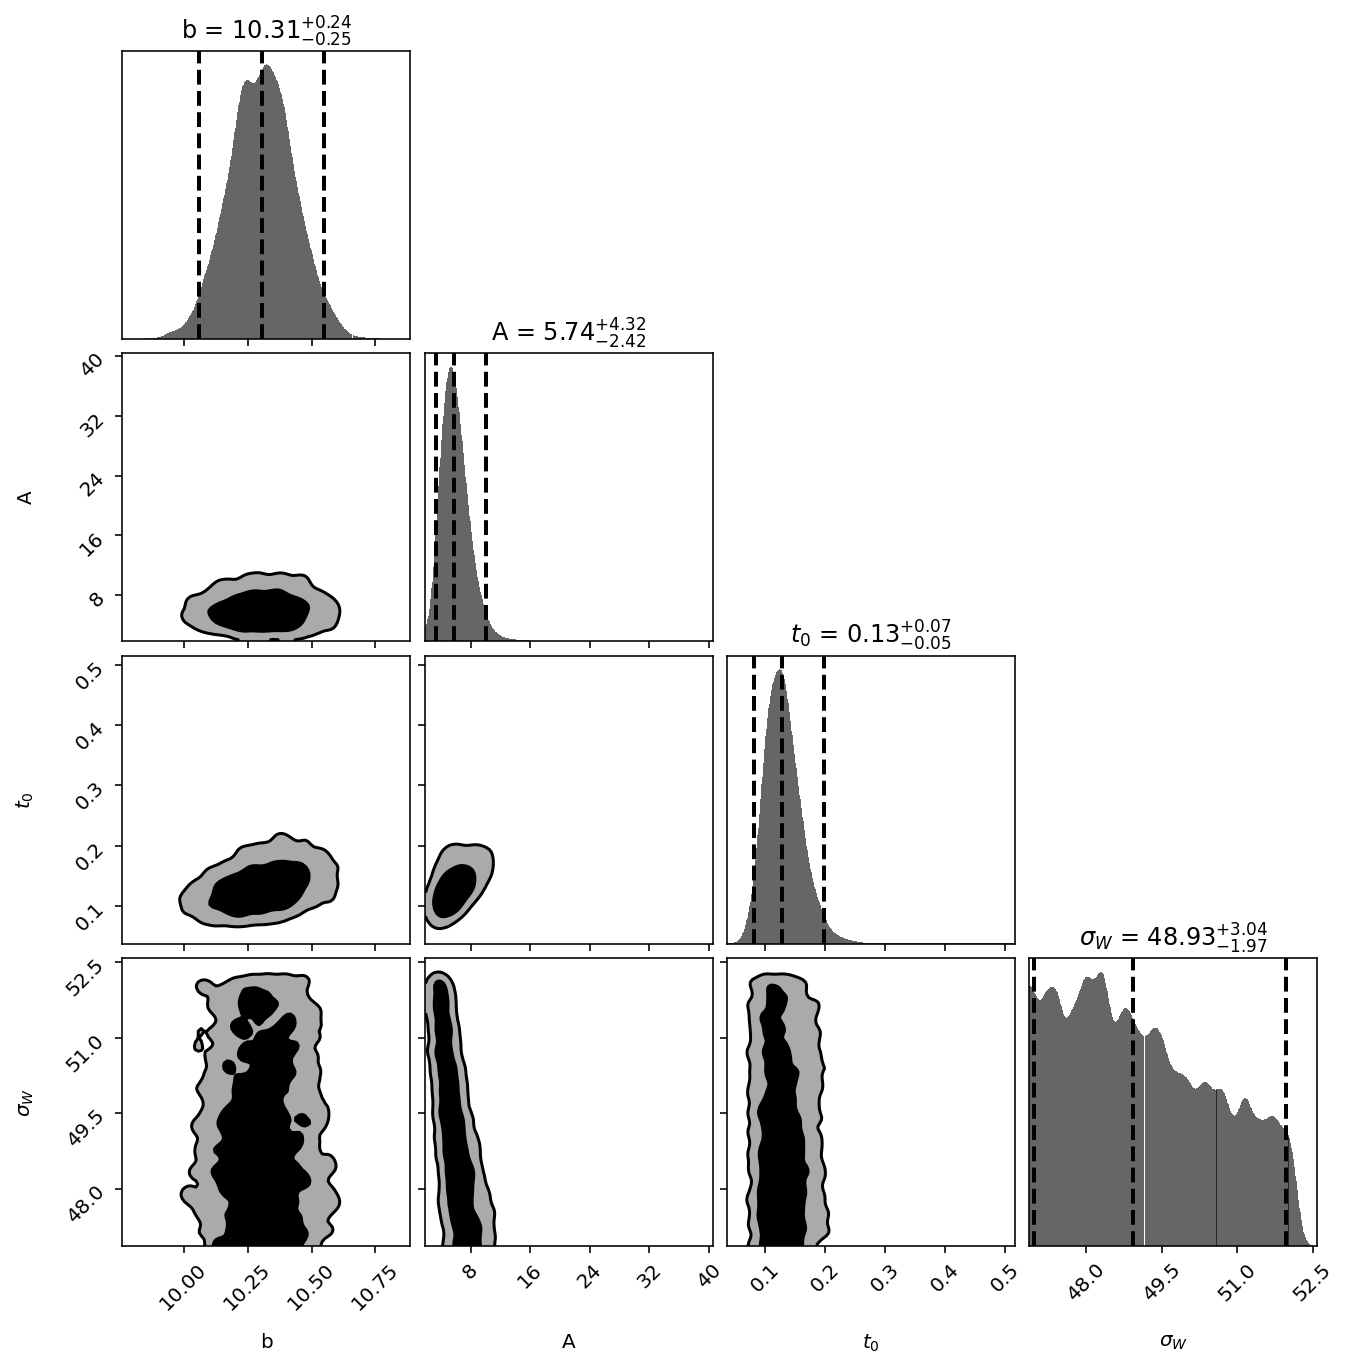

In [202]:
#corner plot of burst model nested sampling to compare with previous corner plot done with ptmcmc
cfig, caxes = dyplot.cornerplot(sresults_burst, labels=['b', 'A', r'$t_0$', r'$\sigma_W$'],
                                quantiles_2d=(0.68,0.95), show_titles=True)

SRT: Yes, but wrong title labels! -1

Looks fairly similar to the corner plot using ptmcmc!

In [206]:
#static nested sampling with gaussian model
sampler = dynesty.NestedSampler(logL2, ptform_gaussian, 4) #ndim = 4
sampler.run_nested()
sresults_gauss = sampler.results 

iter: 8346 | +500 | bound: 41 | nc: 1 | ncall: 48764 | eff(%): 18.140 | loglstar:   -inf < -151.804 <    inf | logz: -167.797 +/-  0.254 | dlogz:  0.001 >  0.509                                     

Evidence is contained in `sampler.results['logz']`, with the final element being the evidence after all iterations are complete.

In [208]:
E_burst = sresults_burst['logz'][-1]
print('Evidence for burst model:', E_burst)
E_gauss = sresults_gauss['logz'][-1]
print('Evidence for Gaussian model:', E_gauss)

Evidence for burst model: -157.23697958893638
Evidence for Gaussian model: -167.79731729277566


In [209]:
Bfactor = E_burst/E_gauss
print('Bayes factor:',Bfactor)

Bayes factor: 0.9370649193073008


So the Bayes factor shows that the Gaussian model is favored in comparison to the burst model, but only slightly.

SRT: Correct procedure, but you have error carried through from your Gaussian burst function. The burst model should be favored over the Gaussian model by about a factor of 100.